Columnas detectadas en el CSV:
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'] 

Usaré estas features:
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'] 

Target:
MEDV 



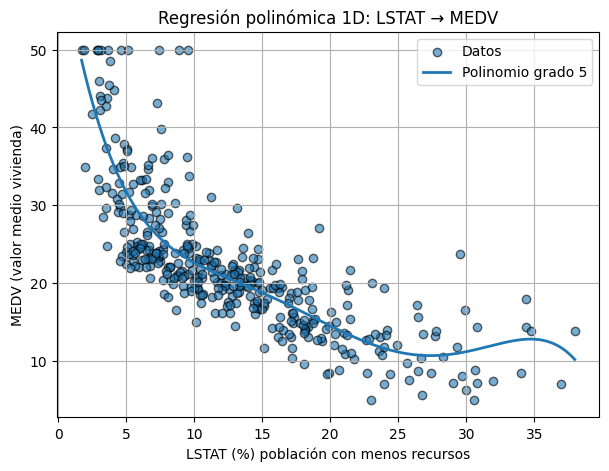

Ridge sin interacciones:         R^2 = 0.657
Ridge con polinomios (grado 2):  R^2 = 0.753
RandomForest sin polinomios:      R^2 = 0.866
RandomForest con polinomios:      R^2 = 0.860


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# --- 1) Carga segura del CSV con cabecera ---
csv_path = Path("./datasets/HousingData.csv")  # ajusta la ruta si hace falta
df = pd.read_csv(csv_path)

print("Columnas detectadas en el CSV:")
print(df.columns.tolist(), "\n")

# Normalizamos nombres para localizar MEDV y LSTAT con independencia de mayúsculas
cols_lower = {c.lower(): c for c in df.columns}

# Detectar target MEDV
target_key = "medv"
if target_key not in cols_lower:
    raise ValueError("No encuentro la columna objetivo 'MEDV' en el CSV (revisa la cabecera).")

y_col = cols_lower[target_key]

# Intentar usar el conjunto clásico de 13 columnas de Boston, si existen
boston_expected = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]
boston_present = [c for c in boston_expected if c in df.columns]

if len(boston_present) >= 5:
    # Usamos todas las que estén disponibles (suele ser el caso estándar)
    feature_cols = boston_present
else:
    # Fallback: todas excepto la target
    feature_cols = [c for c in df.columns if c != y_col]

print("Usaré estas features:")
print(feature_cols, "\n")
print("Target:")
print(y_col, "\n")

# Limpiar NA
df = df.dropna(subset=feature_cols + [y_col]).copy()

# --- 2) Demostración 1D (LSTAT → MEDV) con polinomios ---
if "LSTAT" in df.columns:
    X1 = df[["LSTAT"]].values
    y1 = df[y_col].values

    degree = 5
    pipe_poly = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    pipe_poly.fit(X1, y1)

    # Curva suave para graficar
    lstat_line = np.linspace(df["LSTAT"].min(), df["LSTAT"].max(), 400).reshape(-1, 1)
    yhat_line = pipe_poly.predict(lstat_line)

    plt.figure(figsize=(7,5))
    plt.scatter(df["LSTAT"], df[y_col], alpha=0.6, edgecolor="k", label="Datos")
    plt.plot(lstat_line, yhat_line, lw=2, label=f"Polinomio grado {degree}")
    plt.xlabel("LSTAT (%) población con menos recursos")
    plt.ylabel("MEDV (valor medio vivienda)")
    plt.title("Regresión polinómica 1D: LSTAT → MEDV")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aviso: no encuentro 'LSTAT' en el CSV; omito la demo 1D.\n")

# --- 3) Comparación completa (todas las features disponibles) ---
X = df[feature_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Escalado para modelos lineales con polinomios (evita magnitudes explosivas)
scaler = MinMaxScaler()

# Ridge sin interacciones
ridge_plain = Pipeline([
    ("scale", scaler),
    ("ridge", Ridge())
])
ridge_plain.fit(X_train, y_train)
score_ridge_plain = ridge_plain.score(X_test, y_test)

# Ridge con polinomios (grado 2: cuadrados + TODAS las interacciones)
ridge_poly = Pipeline([
    ("scale", scaler),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge())
])
ridge_poly.fit(X_train, y_train)
score_ridge_poly = ridge_poly.score(X_test, y_test)

# Random Forest sin polinomios
rf_plain = RandomForestRegressor(n_estimators=300, random_state=0)
rf_plain.fit(X_train, y_train)
score_rf_plain = rf_plain.score(X_test, y_test)

# Random Forest con polinomios (suele NO ayudar a árboles)
rf_poly = Pipeline([
    ("scale", scaler),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=0))
])
rf_poly.fit(X_train, y_train)
score_rf_poly = rf_poly.score(X_test, y_test)

print(f"Ridge sin interacciones:         R^2 = {score_ridge_plain:.3f}")
print(f"Ridge con polinomios (grado 2):  R^2 = {score_ridge_poly:.3f}")
print(f"RandomForest sin polinomios:      R^2 = {score_rf_plain:.3f}")
print(f"RandomForest con polinomios:      R^2 = {score_rf_poly:.3f}")
